## Importing data from JSON files

In [4]:
import json
from pathlib import Path

In [5]:
def load_split(split_path):
    texts = []
    labels = []

    for topic_dir in split_path.iterdir():
        if topic_dir.is_dir():
            label = topic_dir.name  # folder name = class label

            for json_file in topic_dir.glob("*.json"):
                with open(json_file, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    texts.append(data["problem"])
                    labels.append(label)

    return texts, labels


base_dir = Path("C:/Users/anika/OneDrive/Desktop/Anika/College/CSI/Task_1/MATH")

X_train, y_train = load_split(base_dir / "train")
X_test, y_test = load_split(base_dir / "test")

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print("Example:", X_train[0], "->", y_train[0])


Train samples: 7500
Test samples: 5000
Example: Let \[f(x) = \left\{
\begin{array}{cl} ax+3, &\text{ if }x>2, \\
x-5 &\text{ if } -2 \le x \le 2, \\
2x-b &\text{ if } x <-2.
\end{array}
\right.\]Find $a+b$ if the piecewise function is continuous (which means that its graph can be drawn without lifting your pencil from the paper). -> algebra


## Baseline Code

In [6]:
wandb.init(
    project="csi-final-check",
    name="baseline-majority",
    config={
        "model": "majority_class"
    }
)

from collections import Counter
from sklearn.metrics import accuracy_score, f1_score

# Find majority class in training data
majority_class = Counter(y_train).most_common(1)[0][0]

# Predict majority class for all test samples
y_pred_baseline = [majority_class] * len(y_test)

# Evaluate baseline
baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline, average="weighted")

print("Baseline Accuracy:", baseline_acc)
print("Baseline F1-score:", baseline_f1)
print("Majority class:", majority_class)

wandb.log({
    "accuracy": baseline_acc,
    "f1_score": baseline_f1
})

wandb.finish()

Baseline Accuracy: 0.2374
Baseline F1-score: 0.0910922256343947
Majority class: algebra


accuracy,▁
f1_score,▁
accuracy,0.2374
f1_score,0.09109


## Training Model 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

wandb.init(
    project="csi-final-check",
    name="tfidf-unigram-nb",
    config={
        "vectorizer": "tfidf",
        "ngrams": "1-1",
        "model": "MultinomialNB"
    }
)

# Vectorization
vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),   # unigrams only
    stop_words="english"
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Prediction
y_pred = model.predict(X_test_vec)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print("Accuracy:", acc)
print("F1-score:", f1)

wandb.log({
    "accuracy": acc,
    "f1_score": f1
})

wandb.finish()

Accuracy: 0.6696
F1-score: 0.661756430122208


accuracy,▁
f1_score,▁
accuracy,0.6696
f1_score,0.66176


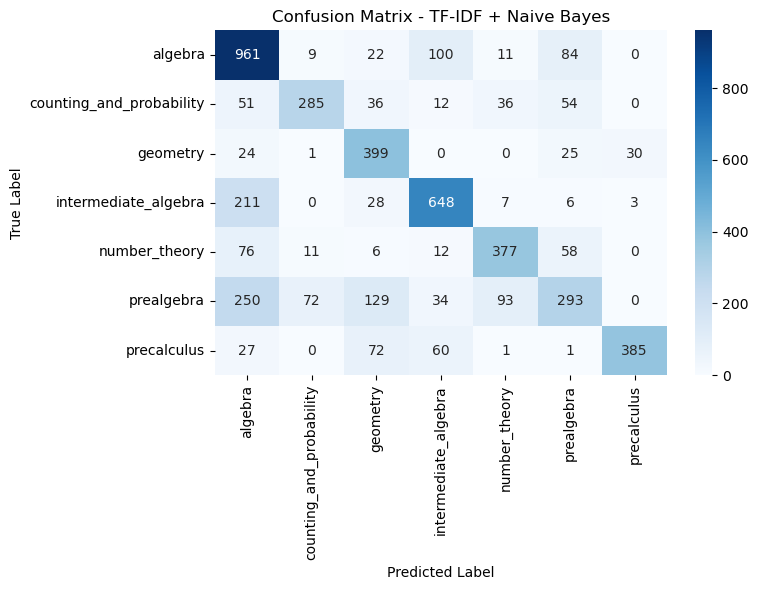

In [33]:
# Encode labels so axes are ordered consistently
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test)

# Recompute confusion matrix with encoded labels
cm = confusion_matrix(y_test_enc, le.transform(y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TF-IDF + Naive Bayes")
plt.tight_layout()
plt.show()

## Ablation 1 - TF-IDF to BoW

In [8]:
wandb.init(
    project="csi-final-check",
    name="bow-unigram-nb",
    config={
        "vectorizer": "bow",
        "ngrams": "1-1",
        "model": "MultinomialNB"
    }
)

from sklearn.feature_extraction.text import CountVectorizer


# Bag-of-Words vectorization
vectorizer_bow = CountVectorizer(
    ngram_range=(1, 1),
    stop_words="english"
)

X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

# Train model
model_bow = MultinomialNB()
model_bow.fit(X_train_bow, y_train)

# Predict
y_pred_bow = model_bow.predict(X_test_bow)

# Evaluate
acc_bow = accuracy_score(y_test, y_pred_bow)
f1_bow = f1_score(y_test, y_pred_bow, average="weighted")
cm_bow = confusion_matrix(y_test, y_pred_bow)

print("BoW Accuracy:", acc_bow)
print("BoW F1-score:", f1_bow)

wandb.log({
    "accuracy": acc_bow,
    "f1_score": f1_bow
})

wandb.finish()

BoW Accuracy: 0.6474
BoW F1-score: 0.6312076558367393


accuracy,▁
f1_score,▁
accuracy,0.6474
f1_score,0.63121


## Ablation 2 - Uingram to Bigram

In [9]:
wandb.init(
    project="csi-final-check",
    name="tfidf-bigram-nb",
    config={
        "vectorizer": "tfidf",
        "ngrams": "1-2",
        "model": "MultinomialNB"
    }
)

# TF-IDF with unigrams + bigrams
vectorizer_ngram = TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_ng = vectorizer_ngram.fit_transform(X_train)
X_test_ng = vectorizer_ngram.transform(X_test)

# Train model
model_ng = MultinomialNB()
model_ng.fit(X_train_ng, y_train)

# Predict
y_pred_ng = model_ng.predict(X_test_ng)

# Evaluate
acc_ng = accuracy_score(y_test, y_pred_ng)
f1_ng = f1_score(y_test, y_pred_ng, average="weighted")
cm_ng = confusion_matrix(y_test, y_pred_ng)

print("N-gram Accuracy:", acc_ng)
print("N-gram F1-score:", f1_ng)

wandb.log({
    "accuracy": acc_ng,
    "f1_score": f1_ng
})

wandb.finish()

N-gram Accuracy: 0.675
N-gram F1-score: 0.6648738457598452


accuracy,▁
f1_score,▁
accuracy,0.675
f1_score,0.66487
